In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
# Read data from CSV files and create sequences
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

scaler = MinMaxScaler()

def read_and_create_sequences(paths, look_back):
    all_X, all_Y = [], []
    for path in paths:
        df = pd.read_csv(path)
        # Drop rows with infinity or extremely large values
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
        # Select required columns
        df = df[['Ax','Ay','Gx','Gy','Gz']]
        
        # Remove outliers using Interquartile Range (IQR)
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]
        
        if len(df) == 0:  # Check if DataFrame is empty after outlier removal
            print(f"Empty DataFrame after outlier removal for file: {path}")
            continue  # Skip processing this file
        
        # Normalize the data
        normalized_data = scaler.fit_transform(df)
        # Convert the data into sequences
        X, Y = [], []
        for i in range(len(normalized_data) - look_back - 1):
            X.append(normalized_data[i:(i + look_back), :])
            Y.append(normalized_data[i + look_back, :])
        all_X.append(X)
        all_Y.append(Y)
    return np.concatenate(all_X), np.concatenate(all_Y)

# Define paths for training and test data
train_paths = ['c_normal.csv','c_abnormal.csv']
test_paths=['ct_normal.csv','ct_abnormal.csv']
# Define the look back for creating sequences
look_back = 30

# Read and create sequences for training data
trainX, trainY = read_and_create_sequences(train_paths, look_back)

# Read and create sequences for test data
testX, testY = read_and_create_sequences(test_paths, look_back)

# Display shapes of train and test data
print(f"Shape Of TrainX: {trainX.shape}")
print(f"Shape Of TrainY: {trainY.shape}")
print(f"Shape Of TestX: {testX.shape}")
print(f"Shape Of TestY: {testY.shape}")


# Define the model
model = Sequential()
model.add(LSTM(128, input_shape=(look_back, 5), return_sequences=False))
model.add(Dense(5))  # Adjust output size to match the number of features

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=481, batch_size=10, verbose=2, validation_split=0.1)

# Make predictions
trainPredict = model.predict(trainX)

# Invert predictions and targets to original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

train_rmse = sqrt(mean_squared_error(trainY, trainPredict))
train_r2 = r2_score(trainY, trainPredict)

print('Train RMSE: %.3f' % train_rmse)
print('Train R2 score: %.3f' % train_r2)

# # Make predictions
testPredict = model.predict(testX)

# Invert predictions and targets to original scale
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

test_rmse = sqrt(mean_squared_error(testY, testPredict))
test_r2 = r2_score(testY, testPredict)

print('test RMSE: %.3f' % test_rmse)
print('test R2 score: %.3f' % test_r2)

import pickle

# Save the model
model.save('my_model.h5')

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
import pandas as pd
import matplotlib.pyplot as plt

dfp = pd.DataFrame({'Actual': testY[:30, 0], 'Predicted': testPredict[:30, 0]})
plt.figure(figsize=(14, 7))
plt.plot(dfp['Actual'], label='Actual')
plt.plot(dfp['Predicted'], label='Predicted')
plt.title('Actual vs Predicted Values for Test Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

import matplotlib.pyplot as plt
dfp = pd.DataFrame({'Actual': trainY[:, 0], 'Predicted': trainPredict[:, 0]})
plt.figure(figsize=(14, 7))
plt.plot(dfp['Actual'], label='Actual')
plt.plot(dfp['Predicted'], label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


Shape Of TrainX: (2538, 30, 5)
Shape Of TrainY: (2538, 5)
Shape Of TestX: (595, 30, 5)
Shape Of TestY: (595, 5)


c:\Users\chand\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/481
229/229 - 5s - 22ms/step - loss: 0.0328 - val_loss: 0.0250
Epoch 2/481
229/229 - 3s - 12ms/step - loss: 0.0282 - val_loss: 0.0214
Epoch 3/481
229/229 - 3s - 12ms/step - loss: 0.0255 - val_loss: 0.0186
Epoch 4/481
229/229 - 3s - 12ms/step - loss: 0.0242 - val_loss: 0.0182
Epoch 5/481
229/229 - 3s - 12ms/step - loss: 0.0237 - val_loss: 0.0172
Epoch 6/481
229/229 - 3s - 11ms/step - loss: 0.0233 - val_loss: 0.0179
Epoch 7/481
229/229 - 3s - 12ms/step - loss: 0.0231 - val_loss: 0.0174
Epoch 8/481
229/229 - 3s - 11ms/step - loss: 0.0226 - val_loss: 0.0168
Epoch 9/481
229/229 - 3s - 12ms/step - loss: 0.0223 - val_loss: 0.0169
Epoch 10/481
229/229 - 3s - 11ms/step - loss: 0.0220 - val_loss: 0.0180
Epoch 11/481
229/229 - 3s - 12ms/step - loss: 0.0219 - val_loss: 0.0166
Epoch 12/481
229/229 - 3s - 13ms/step - loss: 0.0216 - val_loss: 0.0177
Epoch 13/481
229/229 - 3s - 13ms/step - loss: 0.0212 - val_loss: 0.0167
Epoch 14/481
229/229 - 5s - 21ms/step - loss: 0.0213 - val_loss: 0.0164
E

test RMSE: 110.791
test R2 score: -0.030


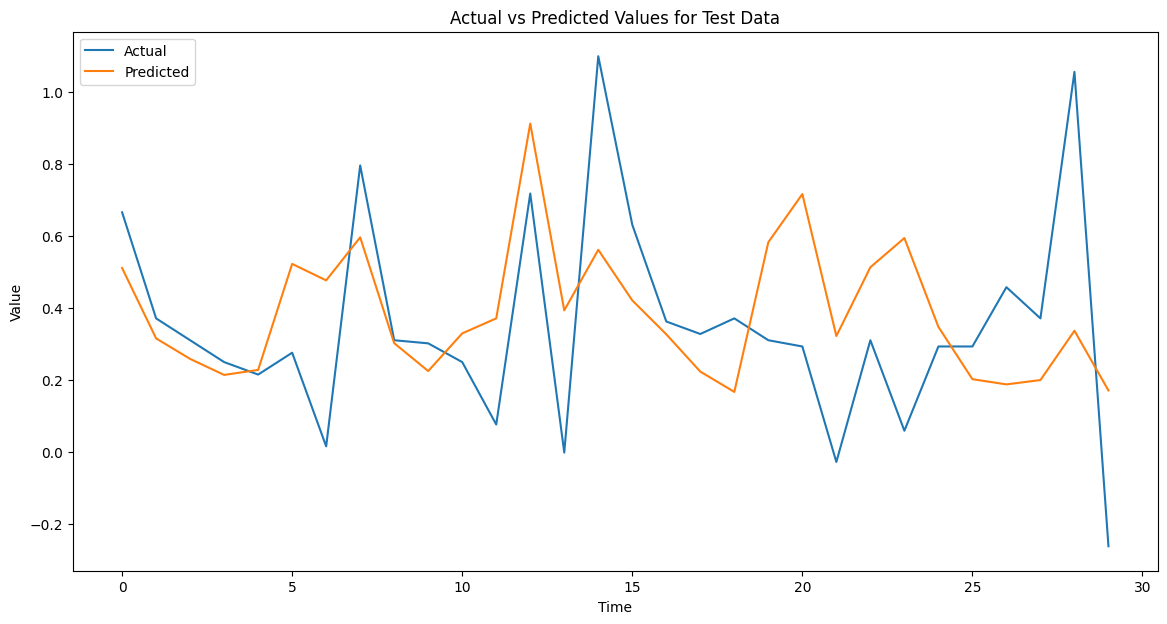

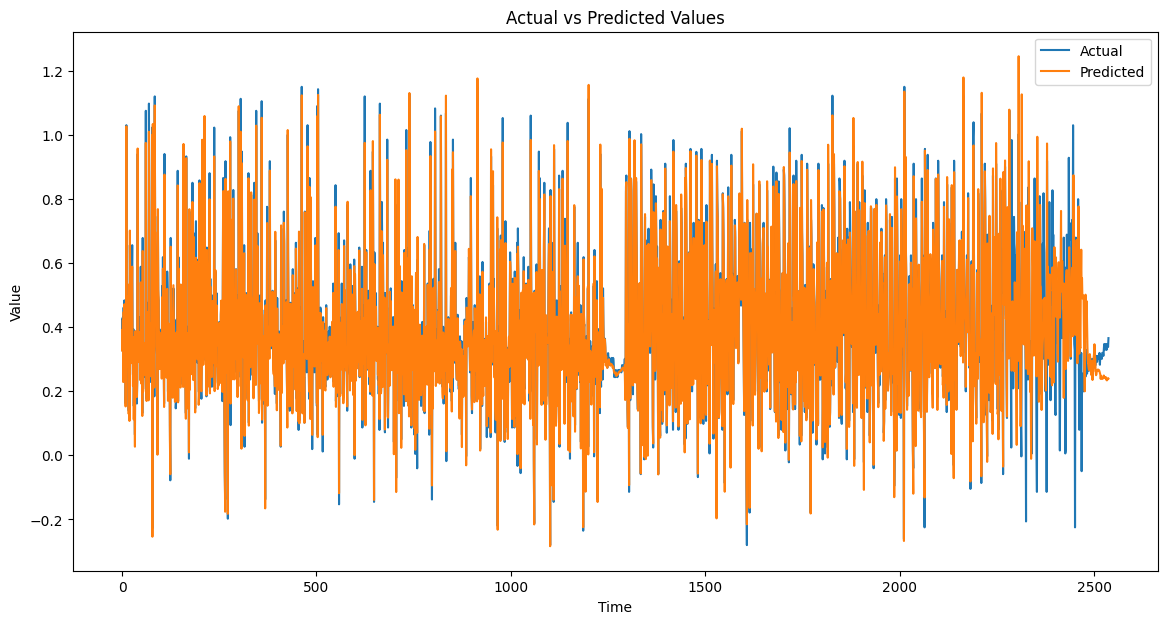

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

dfp = pd.DataFrame({'Actual': testY[:30, 0], 'Predicted': testPredict[:30, 0]})
plt.figure(figsize=(14, 7))
plt.plot(dfp['Actual'], label='Actual')
plt.plot(dfp['Predicted'], label='Predicted')
plt.title('Actual vs Predicted Values for Test Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

import matplotlib.pyplot as plt
dfp = pd.DataFrame({'Actual': trainY[:, 0], 'Predicted': trainPredict[:, 0]})
plt.figure(figsize=(14, 7))
plt.plot(dfp['Actual'], label='Actual')
plt.plot(dfp['Predicted'], label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

Shape Of TrainX: (3612, 30, 5)
Shape Of TrainY: (3612, 5)
Shape Of TestX: (901, 30, 5)
Shape Of TestY: (901, 5)
Epoch 1/481


c:\Users\chand\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


325/325 - 5s - 16ms/step - loss: 0.0222 - val_loss: 0.0106
Epoch 2/481
325/325 - 4s - 11ms/step - loss: 0.0119 - val_loss: 0.0097
Epoch 3/481
325/325 - 5s - 15ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 4/481
325/325 - 4s - 11ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 5/481
325/325 - 3s - 10ms/step - loss: 0.0076 - val_loss: 0.0084
Epoch 6/481
325/325 - 3s - 10ms/step - loss: 0.0072 - val_loss: 0.0088
Epoch 7/481
325/325 - 5s - 16ms/step - loss: 0.0070 - val_loss: 0.0079
Epoch 8/481
325/325 - 3s - 9ms/step - loss: 0.0067 - val_loss: 0.0081
Epoch 9/481
325/325 - 3s - 10ms/step - loss: 0.0065 - val_loss: 0.0076
Epoch 10/481
325/325 - 3s - 10ms/step - loss: 0.0064 - val_loss: 0.0081
Epoch 11/481
325/325 - 4s - 12ms/step - loss: 0.0062 - val_loss: 0.0083
Epoch 12/481
325/325 - 4s - 12ms/step - loss: 0.0061 - val_loss: 0.0076
Epoch 13/481
325/325 - 3s - 11ms/step - loss: 0.0060 - val_loss: 0.0077
Epoch 14/481
325/325 - 3s - 10ms/step - loss: 0.0059 - val_loss: 0.0078
Epoch 15/481
3

test RMSE: 205.833
test R2 score: -0.045


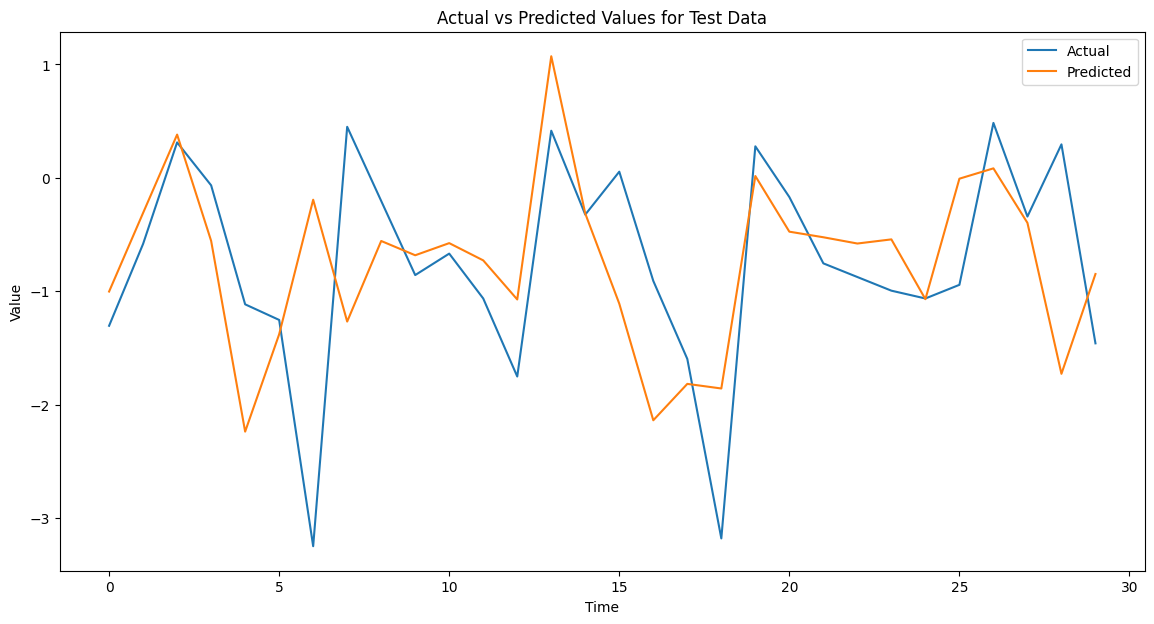

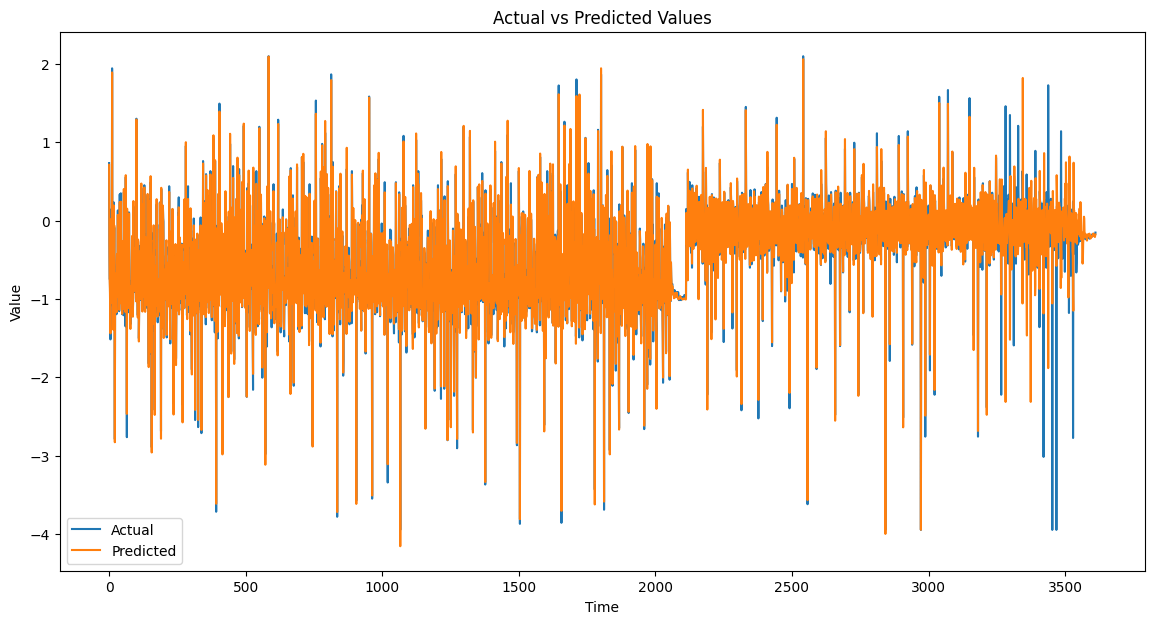

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
# Read data from CSV files and create sequences
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

scaler = MinMaxScaler()

def read_and_create_sequences(paths, look_back):
    all_X, all_Y = [], []
    for path in paths:
        df = pd.read_csv(path)
        # Drop rows with infinity or extremely large values
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
        # Select required columns
        df = df[['Ax','Ay','Gx','Gy','Gz']]
        
        # Normalize the data
        normalized_data = scaler.fit_transform(df)
        # Convert the data into sequences
        X, Y = [], []
        for i in range(len(normalized_data) - look_back - 1):
            X.append(normalized_data[i:(i + look_back), :])
            Y.append(normalized_data[i + look_back, :])
        all_X.append(X)
        all_Y.append(Y)
    return np.concatenate(all_X), np.concatenate(all_Y)

# Define paths for training and test data
train_paths = ['c_normal.csv','c_abnormal.csv']
test_paths=['ct_normal.csv','ct_abnormal.csv']
# Define the look back for creating sequences
look_back = 30

# Read and create sequences for training data
trainX, trainY = read_and_create_sequences(train_paths, look_back)

# Read and create sequences for test data
testX, testY = read_and_create_sequences(test_paths, look_back)

# Display shapes of train and test data
print(f"Shape Of TrainX: {trainX.shape}")
print(f"Shape Of TrainY: {trainY.shape}")
print(f"Shape Of TestX: {testX.shape}")
print(f"Shape Of TestY: {testY.shape}")


# Define the model
model = Sequential()
model.add(LSTM(128, input_shape=(look_back, 5), return_sequences=False))
model.add(Dense(5))  # Adjust output size to match the number of features

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=481, batch_size=10, verbose=2, validation_split=0.1)

# Make predictions
trainPredict = model.predict(trainX)

# Invert predictions and targets to original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

train_rmse = sqrt(mean_squared_error(trainY, trainPredict))
train_r2 = r2_score(trainY, trainPredict)

print('Train RMSE: %.3f' % train_rmse)
print('Train R2 score: %.3f' % train_r2)

# # Make predictions
testPredict = model.predict(testX)

# Invert predictions and targets to original scale
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

test_rmse = sqrt(mean_squared_error(testY, testPredict))
test_r2 = r2_score(testY, testPredict)

print('test RMSE: %.3f' % test_rmse)
print('test R2 score: %.3f' % test_r2)

import pickle

# Save the model
model.save('my_model_with_out.h5')

# Save the scaler
# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)
    
import pandas as pd
import matplotlib.pyplot as plt

dfp = pd.DataFrame({'Actual': testY[:30, 0], 'Predicted': testPredict[:30, 0]})
plt.figure(figsize=(14, 7))
plt.plot(dfp['Actual'], label='Actual')
plt.plot(dfp['Predicted'], label='Predicted')
plt.title('Actual vs Predicted Values for Test Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

import matplotlib.pyplot as plt
dfp = pd.DataFrame({'Actual': trainY[:, 0], 'Predicted': trainPredict[:, 0]})
plt.figure(figsize=(14, 7))
plt.plot(dfp['Actual'], label='Actual')
plt.plot(dfp['Predicted'], label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [2]:
import serial
import csv
import pickle
from datetime import datetime
import keyboard  
import numpy as np
from tensorflow.keras.models import load_model

# Load the model
model = load_model('my_model.h5')

# Load the scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Define the serial port and baud rate
serial_port_tr = 'COM7' 
baud_rate = 9600

# Open serial connection
ser_tr = serial.Serial(serial_port_tr, baud_rate)

try:
    while True:
        line_tr = ser_tr.readline().decode('utf-8').strip()  # Read data from serial transmitter using UTF-8 codec
        timestamp_trans = datetime.now().strftime("%H:%M:%S.%f")  # Transmitter timestamp (hour minute second millisecond)
        
        # Assuming line_tr contains comma-separated values of sensor readings
        sensor_data = [float(val) for val in line_tr.split(',')]
        
        # Assuming sensor_data is a list containing 30 consecutive readings
        real_time_data = np.array(sensor_data).reshape((1, 30, len(sensor_data)))

        # Normalize the data using the previously loaded scaler
        real_time_data = scaler.transform(real_time_data.reshape(-1, len(sensor_data))).reshape(1, 30, len(sensor_data))

        # Make a prediction
        prediction = model.predict(real_time_data)

        # Invert the prediction to the original scale
        prediction = scaler.inverse_transform(prediction)

        # Print or do something with the prediction
        print("Prediction:", prediction)

        # Check if 'a' key is pressed to break the loop
        if keyboard.is_pressed('a'):
            break

except KeyboardInterrupt:
    # Close the serial port when the user interrupts the script
    ser_tr.close()
    print("Serial port closed.")
